In [513]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer


In [514]:
data = pd.read_csv('dados/State_of_data.csv')

In [515]:
# Configurações de estilo

"""plt.style.use('seaborn')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12"""

'plt.style.use(\'seaborn\')\nsns.set_palette("husl")\nplt.rcParams[\'figure.figsize\'] = [12, 8]\nplt.rcParams[\'font.size\'] = 12'

In [516]:
# informações básicas
print("\nInformações do DataFrame:")
print(f"Número de linhas: {data.shape[0]}")
print(f"Número de colunas: {data.shape[1]}")


Informações do DataFrame:
Número de linhas: 5293
Número de colunas: 399


In [517]:
# Verificando valores nulos
print("\nValores nulos por coluna:")
print(data.isnull().sum())


Valores nulos por coluna:
('P0', 'id')                                                                                                                     0
('P1_a ', 'Idade')                                                                                                               0
('P1_a_1 ', 'Faixa idade')                                                                                                       0
('P1_b ', 'Genero')                                                                                                              0
('P1_c ', 'Cor/raca/etnia')                                                                                                      0
                                                                                                                              ... 
('P8_d_8 ', 'Utilizando ferramentas avançadas de estatística como SAS, SPSS, Stata etc, para realizar análises.')             4545
('P8_d_9 ', 'Criando e dando manutenção em ETLs, DAGs e 

In [518]:
# Limpando os nomes das colunas
def limpar_coluna(col):
    import re
    match = re.search(r"'[^']*'\s*,\s*'([^']*)'", col)
    return match.group(1).strip() if match else col.strip()

data.columns = [limpar_coluna(col) for col in data.columns]

In [519]:
# 1. Tratamento de valores nulos
print("\n1.1.1 Tratamento de valores nulos...")

# Selecionando colunas numéricas
numeric_columns = data.select_dtypes(include=[np.number]).columns
data_numeric = data[numeric_columns]


1.1.1 Tratamento de valores nulos...


In [520]:
# Removendo colunas com mais de 30% de valores nulos
print("Removendo colunas com mais de 30% de valores nulos...")
data_numeric = data_numeric.dropna(axis=1, thresh=0.7*len(data_numeric))
print(f"Número de colunas após remoção: {data_numeric.shape[1]}")

# Imputando valores nulos restantes com a média
print("Imputando valores nulos restantes com a média...")
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(data_numeric)

Removendo colunas com mais de 30% de valores nulos...
Número de colunas após remoção: 144
Imputando valores nulos restantes com a média...


In [521]:
# Função para identificar outliers usando IQR
"""
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Tratando outliers na coluna de idade
print("Tratando outliers na coluna de idade...")
data = remove_outliers(data, 'Idade')
"""

'\ndef remove_outliers(df, column):\n    Q1 = df[column].quantile(0.25)\n    Q3 = df[column].quantile(0.75)\n    IQR = Q3 - Q1\n    lower_bound = Q1 - 1.5 * IQR\n    upper_bound = Q3 + 1.5 * IQR\n    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]\n\n# Tratando outliers na coluna de idade\nprint("Tratando outliers na coluna de idade...")\ndata = remove_outliers(data, \'Idade\')\n'

In [522]:
# Padronizando dados numéricos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_imputed)

In [523]:
# Aplicando PCA
pca = PCA()
pca_result = pca.fit_transform(data_scaled)

In [524]:
# Calculando a variância explicada
explained_variance = pca.explained_variance_ratio_

In [525]:
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada Acumulada por Componente')
plt.grid(True)
plt.savefig('variancia_explicada.png')
plt.close()

In [526]:
# Selecionando número de componentes que explicam 95% da variância
n_components = np.argmax(np.cumsum(explained_variance) >= 0.95) + 1
print(f"\nNúmero de componentes necessários para explicar 95% da variância: {n_components}")


Número de componentes necessários para explicar 95% da variância: 98


In [527]:
# Aplicando PCA com número reduzido de componentes
pca = PCA(n_components=n_components)
data_pca = pca.fit_transform(data_scaled)

In [528]:
# Convertendo de volta para DataFrame
data_pca_df = pd.DataFrame(data_pca, columns=[f'PC{i+1}' for i in range(n_components)])

In [529]:
# Adicionando colunas categóricas de volta
categorical_columns = [
    'Cargo Atual', 'Genero', 'Cor/raca/etnia', 'Regiao onde mora', 'PCD',
    'Nível de Ensino', 'Situação de Trabalho', 'Faixa de Experiência', 'Nivel de Ensino', 'Qual sua situação atual de trabalho?'
]
# Verificando quais colunas existem no DataFrame
available_columns = [col for col in categorical_columns if col in data.columns]
print("\nColunas categóricas disponíveis:", available_columns)



Colunas categóricas disponíveis: ['Cargo Atual', 'Genero', 'Cor/raca/etnia', 'Regiao onde mora', 'PCD', 'Nivel de Ensino', 'Qual sua situação atual de trabalho?']


In [530]:
data_processed = pd.concat([data_pca_df, data[available_columns + ['Idade']]], axis=1)

In [531]:
# 5. Verificando o resultado do tratamento
print("\n1.1.5 Verificando resultado do tratamento...")
print("\nValores nulos após tratamento:")
print(data_processed.isnull().sum().sum())

print("\nDimensões do dataset após tratamento:")
print(f"Número de linhas: {data_processed.shape[0]}")
print(f"Número de colunas: {data_processed.shape[1]}")


1.1.5 Verificando resultado do tratamento...

Valores nulos após tratamento:
1560

Dimensões do dataset após tratamento:
Número de linhas: 5293
Número de colunas: 106


In [532]:
# Filtrando apenas os cargos de interesse
cargos_interesse = [
    'Cientista de Dados/Data Scientist',
    'Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect',
    'Analista de Dados/Data Analyst'
]

In [533]:
df_analise = data_processed[data_processed['Cargo Atual'].isin(cargos_interesse)].copy()

# Verificando a distribuição dos cargos
print("\nDistribuição dos cargos:")
print(df_analise['Cargo Atual'].value_counts())


Distribuição dos cargos:
Cargo Atual
Analista de Dados/Data Analyst                                         907
Cientista de Dados/Data Scientist                                      687
Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect    684
Name: count, dtype: int64


In [534]:
# a) Por Gênero
print("\na) Análise por Gênero")

# Histograma por Gênero
for cargo in cargos_interesse:
    plt.figure(figsize=(8, 5))
    for genero in df_analise['Genero'].unique():
        subset = df_analise[(df_analise['Cargo Atual'] == cargo) & (df_analise['Genero'] == genero)]
        if len(subset) > 0:
            plt.hist(subset['Idade'], alpha=0.5, label=f'{genero}', bins=15)
    plt.title(f'Distribuição de Idade - {cargo}')
    plt.xlabel('Idade')
    plt.ylabel('Frequência')
    plt.legend(title='Gênero', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'distribuicao_idade_genero_{cargo.replace("/", "_").replace(" ", "_").lower()}.png')
    plt.close()

# Boxplot por Gênero
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_analise, x='Cargo Atual', y='Idade', hue='Genero')
plt.title('Boxplot de Idade por Cargo e Gênero')
plt.xlabel('Cargo Atual')
plt.ylabel('Idade')
plt.xticks(rotation=30)
plt.legend(title='Gênero', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('boxplot_idade_genero.png')
plt.close()

# Violin Plot por Gênero
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_analise, x='Cargo Atual', y='Idade', hue='Genero', split=True)
plt.title('Violin Plot de Idade por Cargo e Gênero')
plt.xlabel('Cargo Atual')
plt.ylabel('Idade')
plt.xticks(rotation=30)
plt.legend(title='Gênero', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('violinplot_idade_genero.png')
plt.close()

# Estatísticas por Gênero
stats_genero = df_analise.groupby(['Cargo Atual', 'Genero'])['Idade'].agg(['mean', 'std', 'min', 'max']).round(2)
print('\nEstatísticas por Gênero:')
print(stats_genero)


a) Análise por Gênero

Estatísticas por Gênero:
                                                                          mean  \
Cargo Atual                                        Genero                        
Analista de Dados/Data Analyst                     Feminino              30.64   
                                                   Masculino             30.42   
                                                   Outro                 27.50   
                                                   Prefiro não informar  23.00   
Cientista de Dados/Data Scientist                  Feminino              30.95   
                                                   Masculino             29.93   
                                                   Prefiro não informar  34.20   
Engenheiro de Dados/Arquiteto de Dados/Data Eng... Feminino              30.18   
                                                   Masculino             31.04   
                                                 

In [535]:
# b) Por Etnia
print("\nb) Análise por Etnia")

# Histograma por Etnia
for cargo in cargos_interesse:
    plt.figure(figsize=(8, 5))
    for etnia in df_analise['Cor/raca/etnia'].unique():
        subset = df_analise[(df_analise['Cargo Atual'] == cargo) & (df_analise['Cor/raca/etnia'] == etnia)]
        if len(subset) > 0:
            plt.hist(subset['Idade'], alpha=0.5, label=f'{etnia}', bins=15)
    plt.title(f'Distribuição de Idade - {cargo}')
    plt.xlabel('Idade')
    plt.ylabel('Frequência')
    plt.legend(title='Etnia', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'distribuicao_idade_etnia_{cargo.replace("/", "_").replace(" ", "_").lower()}.png')
    plt.close()

# Boxplot por Etnia
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_analise, x='Cargo Atual', y='Idade', hue='Cor/raca/etnia')
plt.title('Boxplot de Idade por Cargo e Etnia')
plt.xlabel('Cargo Atual')
plt.ylabel('Idade')
plt.xticks(rotation=30)
plt.legend(title='Etnia', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('boxplot_idade_etnia.png')
plt.close()

# Violin Plot por Etnia
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_analise, x='Cargo Atual', y='Idade', hue='Cor/raca/etnia', split=True)
plt.title('Violin Plot de Idade por Cargo e Etnia')
plt.xlabel('Cargo Atual')
plt.ylabel('Idade')
plt.xticks(rotation=30)
plt.legend(title='Etnia', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('violinplot_idade_etnia.png')
plt.close()

# Estatísticas por Etnia
stats_etnia = df_analise.groupby(['Cargo Atual', 'Cor/raca/etnia'])['Idade'].agg(['mean', 'std', 'min', 'max']).round(2)
print('\nEstatísticas por Etnia:')
print(stats_etnia)


b) Análise por Etnia

Estatísticas por Etnia:
                                                                          mean  \
Cargo Atual                                        Cor/raca/etnia                
Analista de Dados/Data Analyst                     Amarela               30.66   
                                                   Branca                30.76   
                                                   Indígena              22.00   
                                                   Outra                 28.33   
                                                   Parda                 30.18   
                                                   Prefiro não informar  33.50   
                                                   Preta                 29.16   
Cientista de Dados/Data Scientist                  Amarela               31.66   
                                                   Branca                30.05   
                                                   

In [536]:
df_analise

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC97,PC98,Cargo Atual,Genero,Cor/raca/etnia,Regiao onde mora,PCD,Nivel de Ensino,Qual sua situação atual de trabalho?,Idade
0,5.044329,-4.731957,0.907962,1.163030,0.965171,-0.286545,-1.139646,-0.651227,-1.903896,-4.677760,...,-0.279092,0.194125,Cientista de Dados/Data Scientist,Masculino,Branca,Sudeste,Não,Doutorado ou Phd,Empregado (CLT),31
2,3.783856,-0.236119,2.785419,7.018731,11.624077,-0.985181,3.151462,-1.614320,5.250366,-3.344547,...,1.111886,1.748102,Analista de Dados/Data Analyst,Feminino,Amarela,Sudeste,Não,Graduação/Bacharelado,Empregado (CLT),37
4,-1.015011,-0.423211,1.229826,-0.371060,-1.190924,1.329070,2.575507,-0.854618,-3.018355,-1.574886,...,1.154471,0.461977,Analista de Dados/Data Analyst,Masculino,Branca,Sudeste,Não,Doutorado ou Phd,Empreendedor ou Empregado (CNPJ),34
5,4.440453,0.169835,-0.749787,-2.592761,1.561382,3.603101,-2.903296,-2.183217,-0.679769,-2.373042,...,-3.540467,-0.623258,Engenheiro de Dados/Arquiteto de Dados/Data En...,Masculino,Branca,Sudeste,Não,Estudante de Graduação,Empreendedor ou Empregado (CNPJ),30
16,-2.503270,0.826427,0.353476,0.901080,1.830634,1.827367,0.510725,-0.704181,-4.410474,-0.828851,...,1.369498,0.395926,Analista de Dados/Data Analyst,Feminino,Branca,Sudeste,Não,Graduação/Bacharelado,Servidor Público,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5274,5.900608,0.278086,3.649278,4.668073,-0.311852,3.825655,-3.128686,2.627969,0.112888,-0.652719,...,1.461692,0.878594,Engenheiro de Dados/Arquiteto de Dados/Data En...,Masculino,Preta,Nordeste,Não,Pós-graduação,Empreendedor ou Empregado (CNPJ),31
5278,0.461864,-0.064727,-0.440789,0.593343,0.368717,-0.866316,-1.317268,-0.867860,0.743478,-4.224563,...,0.897517,0.473302,Cientista de Dados/Data Scientist,Masculino,Branca,Nordeste,Não,Graduação/Bacharelado,Empregado (CLT),32
5279,-2.011583,1.996004,-0.899400,-1.871141,1.042816,0.741480,1.088127,-0.657087,-0.706389,-1.024929,...,0.715091,-0.440651,Analista de Dados/Data Analyst,Feminino,Parda,Sudeste,Não,Pós-graduação,Empregado (CLT),36
5281,-3.019962,3.911250,3.700040,-3.863956,0.340954,0.304958,0.554669,6.045647,-0.285912,-0.946383,...,0.794645,0.216557,Analista de Dados/Data Analyst,Masculino,Parda,Centro-oeste,Não,Graduação/Bacharelado,Empregado (CLT),23


In [537]:
pcd_por_regiao = df_analise.groupby('Regiao onde mora')['PCD'].apply(
    lambda x: (x == 'Sim').mean() * 100
).reset_index()
pcd_por_regiao.columns = ['Regiao onde mora', 'Proporção_PcD']

In [538]:
# Criando visualização
plt.figure(figsize=(12, 6))
sns.barplot(data=pcd_por_regiao, x='Regiao onde mora', y='Proporção_PcD')
plt.title('Proporção de Profissionais PcD por Região')
plt.ylabel('Proporção de PcD (%)')
plt.xlabel('Região')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('pcd_por_regiao.png')
plt.close()

In [539]:
# Mostrando estatísticas
print("\nEstatísticas de PcD por região:")
print(pcd_por_regiao.sort_values('Proporção_PcD', ascending=False))


Estatísticas de PcD por região:
  Regiao onde mora  Proporção_PcD
0     Centro-oeste       3.937008
2            Norte       3.846154
3          Sudeste       2.078853
1         Nordeste       1.960784
4              Sul       1.895735


In [540]:
print(data.columns.tolist())

['id', 'Idade', 'Faixa idade', 'Genero', 'Cor/raca/etnia', 'PCD', 'experiencia_profissional_prejudicada', 'Não acredito que minha experiência profissional seja afetada', 'Experiencia prejudicada devido a minha Cor Raça Etnia', 'Experiencia prejudicada devido a minha identidade de gênero', 'Experiencia prejudicada devido ao fato de ser PCD', 'aspectos_prejudicados', 'Quantidade de oportunidades de emprego/vagas recebidas', 'Senioridade das vagas recebidas em relação à sua experiência', 'Aprovação em processos seletivos/entrevistas', 'Oportunidades de progressão de carreira', 'Velocidade de progressão de carreira', 'Nível de cobrança no trabalho/Stress no trabalho', 'Atenção dada diante das minhas opiniões e ideias', 'Relação com outros membros da empresa, em momentos de trabalho', 'Relação com outros membros da empresa, em momentos de integração e outros momentos fora do trabalho', 'vive_no_brasil', 'Estado onde mora', 'uf onde mora', 'Regiao onde mora', 'Mudou de Estado?', 'Regiao de o

## Nivel de Ensino por Cargo e Região

In [541]:
# Criando visualização
plt.figure(figsize=(15, 8))
sns.countplot(data=df_analise, x='Nivel de Ensino', hue='Cargo Atual')
plt.title('Distribuição de Nível de Ensino por Cargo')
plt.xlabel('Nível de Ensino')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
plt.legend(title='Cargo')
plt.tight_layout()
plt.savefig('nivel_ensino_cargo.png')
plt.close()


In [542]:
# Análise por região
print("\nDistribuição de nível de ensino por região:")
for regiao in df_analise['Regiao onde mora'].unique():
    print(f"\nRegião: {regiao}")
    print(df_analise[df_analise['Regiao onde mora'] == regiao]['Nivel de Ensino'].value_counts())



Distribuição de nível de ensino por região:

Região: Sudeste
Nivel de Ensino
Graduação/Bacharelado         571
Pós-graduação                 415
Mestrado                      182
Estudante de Graduação        152
Doutorado ou Phd               54
Não tenho graduação formal     20
Prefiro não informar            1
Name: count, dtype: int64

Região: Nordeste
Nivel de Ensino
Graduação/Bacharelado         85
Pós-graduação                 60
Mestrado                      51
Estudante de Graduação        38
Doutorado ou Phd              15
Não tenho graduação formal     6
Name: count, dtype: int64

Região: Sul
Nivel de Ensino
Pós-graduação                 145
Graduação/Bacharelado         141
Mestrado                       59
Estudante de Graduação         47
Doutorado ou Phd               24
Não tenho graduação formal      5
Prefiro não informar            1
Name: count, dtype: int64

Região: nan
Series([], Name: count, dtype: int64)

Região: Norte
Nivel de Ensino
Graduação/Bacharelado    

## ===============================================
##  distribuição etária por profissão e fatores demográficos.  (Dario)
## ===============================================

In [543]:
colunas_analise = [
    'Regiao onde mora',
    'PCD',
    'Experiencia prejudicada devido ao fato de ser PCD',
    'Nivel de Ensino',
    'Qual sua situação atual de trabalho?',
    'Cargo Atual',
    'Genero',
    'Cor/raca/etnia',
    'Idade'
]

In [544]:
df_analise = data[colunas_analise].copy()

In [545]:
# Verificar valores nulos
print("\nValores nulos por coluna:")
print(df_analise.isnull().sum())

# Verificar valores únicos em cada coluna
print("\nValores únicos em cada coluna:")
for coluna in colunas_analise:
    print(f"\n{coluna}:")
    print(df_analise[coluna].value_counts().head())


Valores nulos por coluna:
Regiao onde mora                                      124
PCD                                                     0
Experiencia prejudicada devido ao fato de ser PCD    2574
Nivel de Ensino                                         0
Qual sua situação atual de trabalho?                    0
Cargo Atual                                          1436
Genero                                                  0
Cor/raca/etnia                                          0
Idade                                                   0
dtype: int64

Valores únicos em cada coluna:

Regiao onde mora:
Regiao onde mora
Sudeste         3173
Sul              961
Nordeste         608
Centro-oeste     344
Norte             83
Name: count, dtype: int64

PCD:
PCD
Não                     5156
Sim                      111
Prefiro não informar      26
Name: count, dtype: int64

Experiencia prejudicada devido ao fato de ser PCD:
Experiencia prejudicada devido ao fato de ser PCD
0.0    2652
1.

In [546]:
# Remover linhas com valores nulos em colunas críticas
colunas_criticas = ['Cargo Atual', 'Genero', 'Cor/raca/etnia', 'Idade']
df_analise = df_analise.dropna(subset=colunas_criticas)

In [547]:
cargos_interesse = [
    'Cientista de Dados/Data Scientist',
    'Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect',
    'Analista de Dados/Data Analyst'
]
df_analise = df_analise[df_analise['Cargo Atual'].isin(cargos_interesse)]

In [548]:
"""Q1 = df_analise['Idade'].quantile(0.25)
Q3 = df_analise['Idade'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

print(f"\nLimites de idade (método IQR):")
print(f"Limite inferior: {limite_inferior:.2f}")
print(f"Limite superior: {limite_superior:.2f}")

outliers = df_analise[(df_analise['Idade'] < limite_inferior) | (df_analise['Idade'] > limite_superior)]
print(f"\nNúmero de outliers de idade: {len(outliers)}")"""

'Q1 = df_analise[\'Idade\'].quantile(0.25)\nQ3 = df_analise[\'Idade\'].quantile(0.75)\nIQR = Q3 - Q1\nlimite_inferior = Q1 - 1.5 * IQR\nlimite_superior = Q3 + 1.5 * IQR\n\nprint(f"\nLimites de idade (método IQR):")\nprint(f"Limite inferior: {limite_inferior:.2f}")\nprint(f"Limite superior: {limite_superior:.2f}")\n\noutliers = df_analise[(df_analise[\'Idade\'] < limite_inferior) | (df_analise[\'Idade\'] > limite_superior)]\nprint(f"\nNúmero de outliers de idade: {len(outliers)}")'

In [549]:
# # Remover outliers
# df_analise = df_analise[(df_analise['Idade'] >= limite_inferior) & (df_analise['Idade'] <= limite_superior)]

In [550]:
# Verificar distribuição após tratamento
print("\nDistribuição após tratamento:")
print("\nTamanho da base de dados:", len(df_analise))
print("\nDistribuição por cargo:")
print(df_analise['Cargo Atual'].value_counts())
print("\nDistribuição por gênero:")
print(df_analise['Genero'].value_counts())
print("\nDistribuição por etnia:")
print(df_analise['Cor/raca/etnia'].value_counts())


Distribuição após tratamento:

Tamanho da base de dados: 2278

Distribuição por cargo:
Cargo Atual
Analista de Dados/Data Analyst                                         907
Cientista de Dados/Data Scientist                                      687
Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect    684
Name: count, dtype: int64

Distribuição por gênero:
Genero
Masculino               1730
Feminino                 538
Prefiro não informar       8
Outro                      2
Name: count, dtype: int64

Distribuição por etnia:
Cor/raca/etnia
Branca                  1483
Parda                    519
Preta                    167
Amarela                   77
Prefiro não informar      20
Outra                      7
Indígena                   5
Name: count, dtype: int64


In [551]:
# Verificar balanceamento dos dados
print("\n=== VERIFICAÇÃO DE BALANCEAMENTO ===")
print("\nNúmero mínimo de observações por grupo:")
min_obs = df_analise.groupby(['Cargo Atual', 'Genero']).size().min()
print(f"Mínimo de observações por grupo (Cargo x Gênero): {min_obs}")


=== VERIFICAÇÃO DE BALANCEAMENTO ===

Número mínimo de observações por grupo:
Mínimo de observações por grupo (Cargo x Gênero): 1


In [552]:
print("\n=== ANÁLISE DE QUALIDADE ===")
print("\nEstatísticas descritivas da idade:")
print(df_analise['Idade'].describe())


=== ANÁLISE DE QUALIDADE ===

Estatísticas descritivas da idade:
count    2278.000000
mean       30.504829
std         6.266846
min        18.000000
25%        26.000000
50%        29.000000
75%        34.000000
max        63.000000
Name: Idade, dtype: float64


In [553]:
# Verificar se há grupos muito pequenos
grupos_pequenos = df_analise.groupby(['Cargo Atual', 'Genero', 'Cor/raca/etnia']).size()
grupos_pequenos = grupos_pequenos[grupos_pequenos < 5]
if len(grupos_pequenos) > 0:
    print("\nGrupos com menos de 5 observações:")
    print(grupos_pequenos)


Grupos com menos de 5 observações:
Cargo Atual                                                          Genero                Cor/raca/etnia      
Analista de Dados/Data Analyst                                       Feminino              Indígena                1
                                                                                           Prefiro não informar    1
                                                                     Masculino             Indígena                1
                                                                                           Outra                   3
                                                                                           Prefiro não informar    1
                                                                     Outro                 Branca                  2
                                                                     Prefiro não informar  Amarela                 1
Cientista de Dados/Data Scientist

In [554]:
# Estatísticas descritivas por gênero e cargo
print("\nEstatísticas descritivas por gênero e cargo:")
stats_genero = df_analise.groupby(['Cargo Atual', 'Genero'])['Idade'].agg(['mean', 'std', 'min', 'max', 'count']).round(2)
print(stats_genero)


Estatísticas descritivas por gênero e cargo:
                                                                          mean  \
Cargo Atual                                        Genero                        
Analista de Dados/Data Analyst                     Feminino              30.64   
                                                   Masculino             30.42   
                                                   Outro                 27.50   
                                                   Prefiro não informar  23.00   
Cientista de Dados/Data Scientist                  Feminino              30.95   
                                                   Masculino             29.93   
                                                   Prefiro não informar  34.20   
Engenheiro de Dados/Arquiteto de Dados/Data Eng... Feminino              30.18   
                                                   Masculino             31.04   
                                                   P

In [555]:
print(stats_genero.columns)

Index(['mean', 'std', 'min', 'max', 'count'], dtype='object')


In [556]:
# Histograma por Gênero
for cargo in cargos_interesse:
    plt.figure(figsize=(10, 6))
    for genero in df_analise['Genero'].unique():
        subset = df_analise[(df_analise['Cargo Atual'] == cargo) & (df_analise['Genero'] == genero)]
        if len(subset) > 0:
            plt.hist(subset['Idade'], alpha=0.5, label=f'{genero}', bins=15)
    plt.title(f'Distribuição de Idade - {cargo}')
    plt.xlabel('Idade')
    plt.ylabel('Frequência')
    plt.legend(title='Gênero')
    plt.tight_layout()
    plt.savefig(f'./dario/distribuicao_idade_genero_{cargo.replace("/", "_").replace(" ", "_").lower()}.png')
    plt.close()

In [557]:
# Boxplot por Gênero
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_analise, x='Cargo Atual', y='Idade', hue='Genero')
plt.title('Boxplot de Idade por Cargo e Gênero')
plt.xlabel('Cargo')
plt.ylabel('Idade')
plt.xticks(rotation=45)
plt.legend(title='Gênero')
plt.tight_layout()
plt.savefig('./dario/boxplot_idade_genero.png')
plt.close()

In [558]:
print("\nEstatísticas descritivas por etnia e cargo:")
stats_etnia = df_analise.groupby(['Cargo Atual', 'Cor/raca/etnia'])['Idade'].agg(['mean', 'std', 'min', 'max', 'count']).round(2)
print(stats_etnia)


Estatísticas descritivas por etnia e cargo:
                                                                          mean  \
Cargo Atual                                        Cor/raca/etnia                
Analista de Dados/Data Analyst                     Amarela               30.66   
                                                   Branca                30.76   
                                                   Indígena              22.00   
                                                   Outra                 28.33   
                                                   Parda                 30.18   
                                                   Prefiro não informar  33.50   
                                                   Preta                 29.16   
Cientista de Dados/Data Scientist                  Amarela               31.66   
                                                   Branca                30.05   
                                                   In

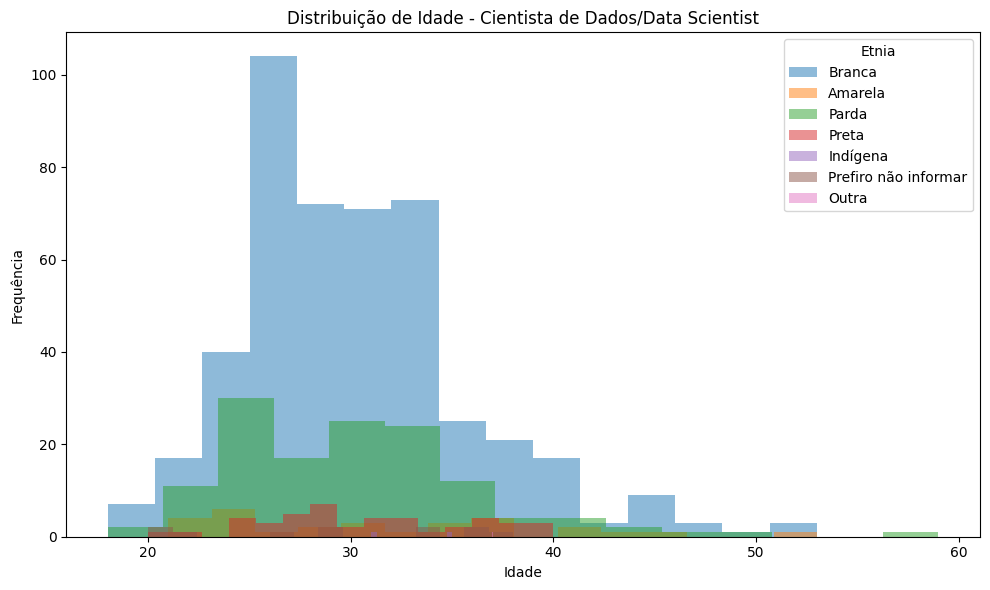

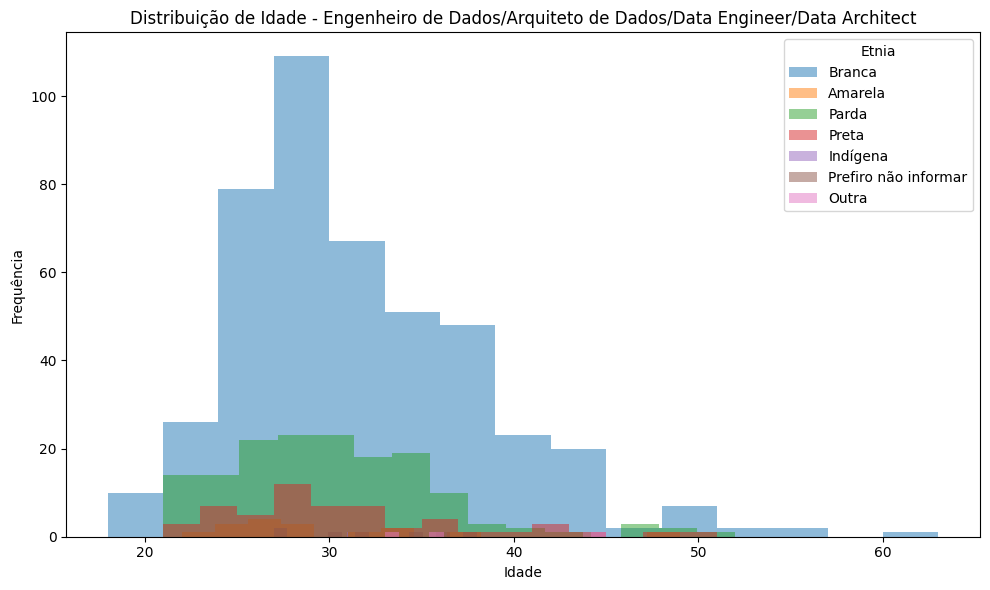

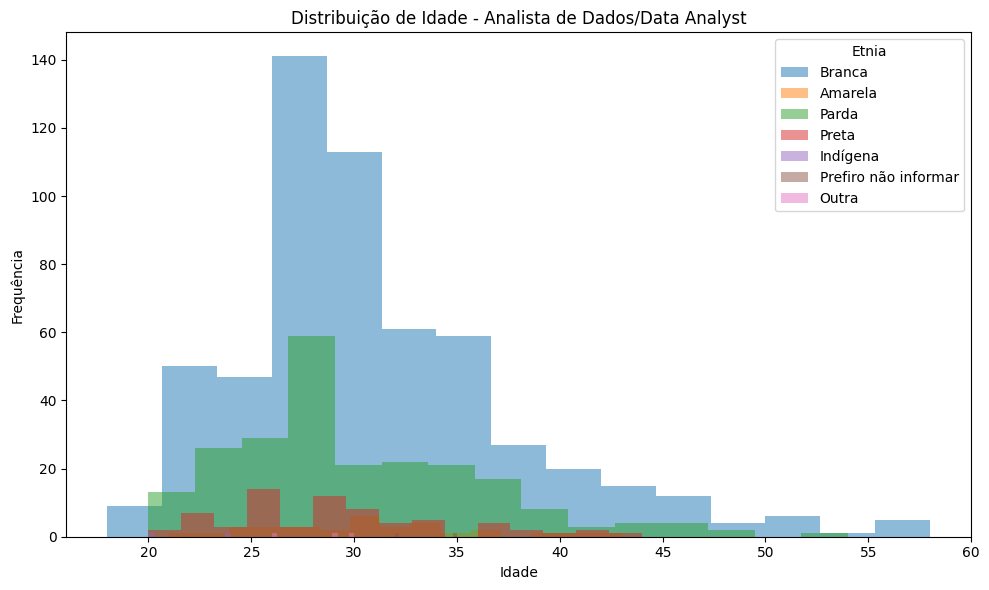

In [559]:
# Histograma por Etnia
for cargo in cargos_interesse:
    plt.figure(figsize=(10, 6))
    for etnia in df_analise['Cor/raca/etnia'].unique():
        subset = df_analise[(df_analise['Cargo Atual'] == cargo) & (df_analise['Cor/raca/etnia'] == etnia)]
        if len(subset) > 0:
            plt.hist(subset['Idade'], alpha=0.5, label=f'{etnia}', bins=15)
    plt.title(f'Distribuição de Idade - {cargo}')
    plt.xlabel('Idade')
    plt.ylabel('Frequência')
    plt.legend(title='Etnia')
    plt.tight_layout()
    plt.show(f'distribuicao_idade_etnia_{cargo.replace("/", "_").replace(" ", "_").lower()}.png')
    plt.close()

In [560]:
 #Por Etnia
from scipy import stats


print("\nPor Etnia:")
for cargo in cargos_interesse:
    grupos = [df_analise[(df_analise['Cargo Atual'] == cargo) & (df_analise['Cor/raca/etnia'] == etnia)]['Idade'] 
              for etnia in df_analise['Cor/raca/etnia'].unique()]
    f_stat, p_valor = stats.f_oneway(*grupos)
    print(f"\n{cargo}:")
    print(f"F-statistic: {f_stat:.2f}")
    print(f"p-valor: {p_valor:.4f}")


Por Etnia:

Cientista de Dados/Data Scientist:
F-statistic: 0.74
p-valor: 0.6180

Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect:
F-statistic: 0.96
p-valor: 0.4485

Analista de Dados/Data Analyst:
F-statistic: 1.45
p-valor: 0.1912


## ===============================================
##  Concentração de Profissionais PcD por Região  (Tiago)
## ===============================================

In [561]:
colunas_analise = [
    'Regiao onde mora',
    'PCD',
    'Experiencia prejudicada devido ao fato de ser PCD',
    'Nivel de Ensino',
    'Qual sua situação atual de trabalho?',
    'Cargo Atual',
    'Genero',
    'Cor/raca/etnia'
]

df_analise = data[colunas_analise].copy()

In [562]:
# Verificar valores nulos
print("\nValores nulos por coluna:")
print(df_analise.isnull().sum())

# Verificar valores únicos em cada coluna
print("\nValores únicos em cada coluna:")
for coluna in colunas_analise:
    print(f"\n{coluna}:")
    print(df_analise[coluna].value_counts().head())

# Remover linhas onde PCD é nulo
df_analise = df_analise.dropna(subset=['PCD'])


Valores nulos por coluna:
Regiao onde mora                                      124
PCD                                                     0
Experiencia prejudicada devido ao fato de ser PCD    2574
Nivel de Ensino                                         0
Qual sua situação atual de trabalho?                    0
Cargo Atual                                          1436
Genero                                                  0
Cor/raca/etnia                                          0
dtype: int64

Valores únicos em cada coluna:

Regiao onde mora:
Regiao onde mora
Sudeste         3173
Sul              961
Nordeste         608
Centro-oeste     344
Norte             83
Name: count, dtype: int64

PCD:
PCD
Não                     5156
Sim                      111
Prefiro não informar      26
Name: count, dtype: int64

Experiencia prejudicada devido ao fato de ser PCD:
Experiencia prejudicada devido ao fato de ser PCD
0.0    2652
1.0      67
Name: count, dtype: int64

Nivel de Ensino:
Nive

In [563]:
def analise_estatistica_completa(df):
    print("\n=== Análise de Valores Nulos ===")
    valores_nulos = df.isnull().sum()
    print(valores_nulos)
    
    print("\n=== Análise de Valores Únicos por Coluna ===")
    for coluna in df.columns:
        print(f"\n{coluna}:")
        print(df[coluna].value_counts())
        print(f"Total de valores únicos: {df[coluna].nunique()}")

def analise_estatistica_numerica(df, coluna):

    if coluna not in df.columns:
        raise ValueError(f"Coluna '{coluna}' não encontrada no DataFrame")
    
    estatisticas = {
        'Média': df[coluna].mean(),
        'Mediana': df[coluna].median(),
        'Variância': df[coluna].var(),
        'Desvio Padrão': df[coluna].std(),
        'Quartis': {
            'Q1': df[coluna].quantile(0.25),
            'Q2': df[coluna].quantile(0.50),
            'Q3': df[coluna].quantile(0.75)
        },
        'Mínimo': df[coluna].min(),
        'Máximo': df[coluna].max()
    }
    
    return estatisticas

def imprimir_estatisticas(estatisticas):

    print("\n=== Análise Estatística ===")
    print(f"Média: {estatisticas['Média']:.2f}")
    print(f"Mediana: {estatisticas['Mediana']:.2f}")
    print(f"Variância: {estatisticas['Variância']:.2f}")
    print(f"Desvio Padrão: {estatisticas['Desvio Padrão']:.2f}")
    print("\nQuartis:")
    print(f"Q1 (25%): {estatisticas['Quartis']['Q1']:.2f}")
    print(f"Q2 (50%): {estatisticas['Quartis']['Q2']:.2f}")
    print(f"Q3 (75%): {estatisticas['Quartis']['Q3']:.2f}")
    print(f"\nMínimo: {estatisticas['Mínimo']:.2f}")
    print(f"Máximo: {estatisticas['Máximo']:.2f}")
    
    
analise_estatistica_completa(df_analise)


=== Análise de Valores Nulos ===
Regiao onde mora                                      124
PCD                                                     0
Experiencia prejudicada devido ao fato de ser PCD    2574
Nivel de Ensino                                         0
Qual sua situação atual de trabalho?                    0
Cargo Atual                                          1436
Genero                                                  0
Cor/raca/etnia                                          0
dtype: int64

=== Análise de Valores Únicos por Coluna ===

Regiao onde mora:
Regiao onde mora
Sudeste         3173
Sul              961
Nordeste         608
Centro-oeste     344
Norte             83
Name: count, dtype: int64
Total de valores únicos: 5

PCD:
PCD
Não                     5156
Sim                      111
Prefiro não informar      26
Name: count, dtype: int64
Total de valores únicos: 3

Experiencia prejudicada devido ao fato de ser PCD:
Experiencia prejudicada devido ao fato de ser P

In [564]:
print("\nDistribuição por Gênero:")
genero_pcd = df_analise[df_analise['PCD'] == 'Sim']['Genero'].value_counts()
print(genero_pcd)


Distribuição por Gênero:
Genero
Masculino    75
Feminino     36
Name: count, dtype: int64


In [565]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_analise[df_analise['PCD'] == 'Sim'], x='Genero')
plt.title('Distribuição de PcDs por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./tiago/pcd_por_genero.png')
plt.close()

In [566]:
# Distribuição por Cor/Raça/Etnia
print("\nDistribuição por Cor/Raça/Etnia:")
etnia_pcd = df_analise[df_analise['PCD'] == 'Sim']['Cor/raca/etnia'].value_counts()
print(etnia_pcd)

plt.figure(figsize=(10, 6))
sns.countplot(data=df_analise[df_analise['PCD'] == 'Sim'], x='Cor/raca/etnia')
plt.title('Distribuição de PcDs por Cor/Raça/Etnia')
plt.xlabel('Cor/Raça/Etnia')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./tiago/pcd_por_etnia.png')
plt.close()


Distribuição por Cor/Raça/Etnia:
Cor/raca/etnia
Branca      68
Parda       33
Preta        7
Amarela      2
Indígena     1
Name: count, dtype: int64


In [567]:
print("\n=== ANÁLISE PROFISSIONAL DOS PCDs ===")

# Distribuição por Cargo
print("\nDistribuição por Cargo:")
cargo_pcd = df_analise[df_analise['PCD'] == 'Sim']['Cargo Atual'].value_counts()
print(cargo_pcd)


=== ANÁLISE PROFISSIONAL DOS PCDs ===

Distribuição por Cargo:
Cargo Atual
Analista de Dados/Data Analyst                                         20
Cientista de Dados/Data Scientist                                      16
Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect    12
Analista de BI/BI Analyst                                              11
Outra Opção                                                             6
Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas             5
Analista de Negócios/Business Analyst                                   5
Analytics Engineer                                                      5
Outras Engenharias (não inclui dev)                                     2
Engenheiro de Machine Learning/ML Engineer/AI Engineer                  1
DBA/Administrador de Banco de Dados                                     1
Name: count, dtype: int64


In [568]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_analise[df_analise['PCD'] == 'Sim'], y='Cargo Atual')
plt.title('Distribuição de PcDs por Cargo')
plt.xlabel('Quantidade')
plt.ylabel('Cargo')
plt.tight_layout()
plt.savefig('./tiago/pcd_por_cargo.png')
plt.close()

In [569]:
# 3. Análise Regional Detalhada
print("\n=== ANÁLISE REGIONAL DETALHADA ===")

# Proporção de PcDs por região
total_por_regiao = df_analise.groupby('Regiao onde mora').size()
pcd_por_regiao = df_analise[df_analise['PCD'] == 'Sim'].groupby('Regiao onde mora').size()
proporcao_pcd = (pcd_por_regiao / total_por_regiao * 100).round(2)

print("\nProporção de PcDs por região (%):")
print(proporcao_pcd)


=== ANÁLISE REGIONAL DETALHADA ===

Proporção de PcDs por região (%):
Regiao onde mora
Centro-oeste    3.49
Nordeste        1.97
Norte           6.02
Sudeste         1.92
Sul             1.98
dtype: float64


In [570]:
# Visualização da proporção de PcDs por região
plt.figure(figsize=(12, 6))
sns.barplot(x=proporcao_pcd.index, y=proporcao_pcd.values)
plt.title('Proporção de Profissionais PcD por Região')
plt.xlabel('Região')
plt.ylabel('Proporção de PcD (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./tiago/proporcao_pcd_regiao.png')
plt.close()

In [571]:
media_nacional = (df_analise['PCD'] == 'Sim').mean() * 100
disparidade = abs(proporcao_pcd - media_nacional) # abs -> valores absolutos

print("\nDisparidade absoluta em relação à média nacional (%):")
print(disparidade.round(2))


Disparidade absoluta em relação à média nacional (%):
Regiao onde mora
Centro-oeste    1.39
Nordeste        0.13
Norte           3.92
Sudeste         0.18
Sul             0.12
dtype: float64


In [572]:
# Visualização das disparidades
plt.figure(figsize=(12, 6))
sns.barplot(x=disparidade.index, y=disparidade.values)
plt.title('Disparidade na Proporção de PcDs por Região\nem relação à Média Nacional')
plt.xlabel('Região')
plt.ylabel('Diferença absoluta em relação à média nacional (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('disparidade_pcd_regiao.png')
plt.close()

## ===============================================
##  Nível de Ensino por Cargo e Região  (Renato)
## ===============================================

In [573]:

# Selecionar colunas relevantes com nomes exatos
colunas_analise = [
    'Nivel de Ensino',
    'Cargo Atual',
    'Regiao onde mora'
]


df_analise = data[colunas_analise].copy()

# Verificar valores nulos em df_analise antes do tratamento
print("\nValores nulos em df_analise antes do dropna():")
print(df_analise.isnull().sum())

# Imprimir valores únicos de cada coluna em df_analise antes de remover nulos (após a criação)
print("\nValores únicos em 'Cargo Atual' (em df_analise antes de dropna):")
print(df_analise['Cargo Atual'].unique())
print("\nValores únicos em 'Nivel de Ensino' (em df_analise antes de dropna):")
print(df_analise['Nivel de Ensino'].unique())
print("\nValores únicos em 'Regiao onde mora' (em df_analise antes de dropna):")
print(df_analise['Regiao onde mora'].unique())


Valores nulos em df_analise antes do dropna():
Nivel de Ensino        0
Cargo Atual         1436
Regiao onde mora     124
dtype: int64

Valores únicos em 'Cargo Atual' (em df_analise antes de dropna):
['Cientista de Dados/Data Scientist' 'Analista de BI/BI Analyst'
 'Analista de Dados/Data Analyst' nan
 'Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect'
 'Analista de Negócios/Business Analyst' 'Outra Opção'
 'Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas'
 'Professor/Pesquisador' 'Analytics Engineer' 'Economista' 'Estatístico'
 'Analista de Suporte/Analista Técnico'
 'Data Product Manager/ Product Manager (PM/APM/DPM/GPM/PO)'
 'Outras Engenharias (não inclui dev)'
 'Analista de Inteligência de Mercado/Market Intelligence'
 'Engenheiro de Machine Learning/ML Engineer/AI Engineer'
 'DBA/Administrador de Banco de Dados']

Valores únicos em 'Nivel de Ensino' (em df_analise antes de dropna):
['Doutorado ou Phd' 'Graduação/Bacharelado' 'Estudante de Graduaçã

In [574]:
analise_estatistica_completa(df_analise)


=== Análise de Valores Nulos ===
Nivel de Ensino        0
Cargo Atual         1436
Regiao onde mora     124
dtype: int64

=== Análise de Valores Únicos por Coluna ===

Nivel de Ensino:
Nivel de Ensino
Pós-graduação                 1818
Graduação/Bacharelado         1798
Estudante de Graduação         678
Mestrado                       676
Doutorado ou Phd               210
Não tenho graduação formal     105
Prefiro não informar             8
Name: count, dtype: int64
Total de valores únicos: 7

Cargo Atual:
Cargo Atual
Analista de Dados/Data Analyst                                         907
Cientista de Dados/Data Scientist                                      687
Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect    684
Analista de BI/BI Analyst                                              506
Outra Opção                                                            262
Analista de Negócios/Business Analyst                                  195
Analytics Engineer      

In [575]:
df_analise = df_analise.dropna(subset=colunas_analise)

# Imprimir valores únicos de cada coluna após remover nulos
print("\nValores únicos em 'Cargo Atual' (após dropna):")
print(df_analise['Cargo Atual'].unique())
print("\nValores únicos em 'Nivel de Ensino' (após dropna):")
print(df_analise['Nivel de Ensino'].unique())
print("\nValores únicos em 'Regiao onde mora' (após dropna):")
print(df_analise['Regiao onde mora'].unique())

# Filtrar categorias mais relevantes
# Cargos: manter apenas os principais cargos de dados
cargos_principais = [
    'Cientista de Dados/Data Scientist',
    'Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect',
    'Analista de Dados/Data Analyst'
]
df_analise = df_analise[df_analise['Cargo Atual'].isin(cargos_principais)]


Valores únicos em 'Cargo Atual' (após dropna):
['Cientista de Dados/Data Scientist' 'Analista de BI/BI Analyst'
 'Analista de Dados/Data Analyst'
 'Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect'
 'Analista de Negócios/Business Analyst' 'Outra Opção'
 'Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas'
 'Professor/Pesquisador' 'Analytics Engineer' 'Economista' 'Estatístico'
 'Analista de Suporte/Analista Técnico'
 'Data Product Manager/ Product Manager (PM/APM/DPM/GPM/PO)'
 'Outras Engenharias (não inclui dev)'
 'Analista de Inteligência de Mercado/Market Intelligence'
 'Engenheiro de Machine Learning/ML Engineer/AI Engineer'
 'DBA/Administrador de Banco de Dados']

Valores únicos em 'Nivel de Ensino' (após dropna):
['Doutorado ou Phd' 'Graduação/Bacharelado' 'Estudante de Graduação'
 'Pós-graduação' 'Mestrado' 'Não tenho graduação formal'
 'Prefiro não informar']

Valores únicos em 'Regiao onde mora' (após dropna):
['Sudeste' 'Nordeste' 'Sul' 'Norte' 'C

In [576]:
# Adicionar nova célula para estatísticas descritivas
print("\n=== ESTATÍSTICAS DESCRITIVAS COMPLETAS ===")

# 1. Estatísticas Descritivas para Variáveis Numéricas
print("\n1. Estatísticas Descritivas para Variáveis Numéricas:")
numeric_stats = data.select_dtypes(include=[np.number]).describe()
print(numeric_stats)

# 2. Estatísticas Descritivas para Variáveis Categóricas
print("\n2. Estatísticas Descritivas para Variáveis Categóricas:")
categorical_columns = ['Cargo Atual', 'Nivel de Ensino', 'Regiao onde mora', 'Genero']
for col in categorical_columns:
    print(f"\nDistribuição de {col}:")
    print(data[col].value_counts())
    print("\nProporções:")
    print((data[col].value_counts(normalize=True) * 100).round(2))

# 3. Análise de Correlação
print("\n3. Matriz de Correlação para Variáveis Numéricas:")
correlation_matrix = data.select_dtypes(include=[np.number]).corr()
print(correlation_matrix)

# 4. Análise de Associação entre Variáveis Categóricas
print("\n4. Análise de Associação entre Variáveis Categóricas:")
from scipy.stats import chi2_contingency

for i in range(len(categorical_columns)):
    for j in range(i+1, len(categorical_columns)):
        col1, col2 = categorical_columns[i], categorical_columns[j]
        contingency_table = pd.crosstab(data[col1], data[col2])
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        print(f"\nAssociação entre {col1} e {col2}:")
        print(f"Chi-quadrado: {chi2:.2f}")
        print(f"Valor-p: {p_value:.4f}")
        print(f"Graus de liberdade: {dof}")

# 6. Resumo das Principais Descobertas
print("\n=== RESUMO DAS PRINCIPAIS DESCOBERTAS ===")

# 6.1 Estatísticas de Tendência Central
print("\n1. Estatísticas de Tendência Central para Idade:")
print(f"Média: {data['Idade'].mean():.2f}")
print(f"Mediana: {data['Idade'].median():.2f}")
print(f"Moda: {data['Idade'].mode()[0]:.2f}")

# 6.2 Distribuição de Cargos
print("\n2. Cargos mais comuns:")
print(data['Cargo Atual'].value_counts().head(3))

# 6.3 Distribuição de Nível de Ensino
print("\n3. Níveis de ensino mais comuns:")
print(data['Nivel de Ensino'].value_counts().head(3))

# 6.4 Distribuição Regional
print("\n4. Distribuição por região:")
print(data['Regiao onde mora'].value_counts())


=== ESTATÍSTICAS DESCRITIVAS COMPLETAS ===

1. Estatísticas Descritivas para Variáveis Numéricas:
             Idade  \
count  5293.000000   
mean     31.997166   
std       7.623498   
min      18.000000   
25%      27.000000   
50%      30.000000   
75%      36.000000   
max      73.000000   

       Não acredito que minha experiência profissional seja afetada  \
count                                        2719.000000              
mean                                            0.542111              
std                                             0.498315              
min                                             0.000000              
25%                                             0.000000              
50%                                             1.000000              
75%                                             1.000000              
max                                             1.000000              

       Experiencia prejudicada devido a minha Cor Raça Etnia  

In [577]:
# Nível de Ensino: manter apenas as categorias principais
niveis_principais = [
    'Graduação/Bacharelado',
    'Pós-graduação',
    'Mestrado',
    'Doutorado ou Phd'
]
df_analise = df_analise[df_analise['Nivel de Ensino'].isin(niveis_principais)]

In [578]:
df_analise['Nivel de Ensino'] = pd.Categorical(
    df_analise['Nivel de Ensino'],
    categories=niveis_principais,
    ordered=True
)

In [579]:
# 2.1 Proporção geral de níveis de ensino
print("\n=== PROPORÇÃO GERAL DE NÍVEIS DE ENSINO ===")
nivel_geral = df_analise['Nivel de Ensino'].value_counts(normalize=True) * 100
print("\nProporção geral de níveis de ensino (%):")
print(nivel_geral.round(2))

# 2.2 Distribuição por cargo
print("\n=== DISTRIBUIÇÃO POR CARGO ===")
nivel_cargo = pd.crosstab(df_analise['Cargo Atual'], 
                         df_analise['Nivel de Ensino'], 
                         normalize='index') * 100
print("\nDistribuição de nível de ensino por cargo (%):")
print(nivel_cargo.round(2))

# 2.3 Análise por cargo e região
print("\n=== ANÁLISE POR CARGO E REGIÃO ===")
nivel_cargo_regiao = pd.crosstab([df_analise['Cargo Atual'], df_analise['Regiao onde mora']], 
                                df_analise['Nivel de Ensino'], 
                                normalize='index') * 100
print("\nDistribuição de nível de ensino por cargo e região (%):")
print(nivel_cargo_regiao.round(2))


=== PROPORÇÃO GERAL DE NÍVEIS DE ENSINO ===

Proporção geral de níveis de ensino (%):
Nivel de Ensino
Graduação/Bacharelado    43.88
Pós-graduação            34.80
Mestrado                 16.00
Doutorado ou Phd          5.32
Name: proportion, dtype: float64

=== DISTRIBUIÇÃO POR CARGO ===

Distribuição de nível de ensino por cargo (%):
Nivel de Ensino                                     Graduação/Bacharelado  \
Cargo Atual                                                                 
Analista de Dados/Data Analyst                                      45.23   
Cientista de Dados/Data Scientist                                   37.09   
Engenheiro de Dados/Arquiteto de Dados/Data Eng...                  49.22   

Nivel de Ensino                                     Pós-graduação  Mestrado  \
Cargo Atual                                                                   
Analista de Dados/Data Analyst                              42.18     10.34   
Cientista de Dados/Data Scientist    

In [580]:
plt.figure(figsize=(10, 6))
nivel_geral.plot(kind='bar')
plt.title('Proporção Geral de Níveis de Ensino')
plt.xlabel('Nível de Ensino')
plt.ylabel('Proporção (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('./renato/nivel_ensino_geral.png')
plt.close()

In [581]:
plt.figure(figsize=(14, 7))
# Reformatar os dados para o gráfico agrupado
nivel_cargo_unstacked = nivel_cargo.stack().reset_index()
nivel_cargo_unstacked.columns = ['Cargo', 'Nivel de Ensino', 'Proporcao']  # Renomear colunas explicitamente
sns.barplot(data=nivel_cargo_unstacked, x='Cargo', y='Proporcao', hue='Nivel de Ensino')
plt.title('Distribuição de Nível de Ensino por Cargo')
plt.xlabel('Cargo')
plt.ylabel('Proporção (%)')
plt.xticks(rotation=45)
plt.legend(title='Nível de Ensino', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('./renato/nivel_ensino_cargo.png')
plt.close()

In [582]:
plt.figure(figsize=(15, 8))
sns.heatmap(nivel_cargo_regiao, annot=True, fmt='.1f', cmap='YlOrRd')
plt.title('Distribuição de Nível de Ensino por Cargo e Região')
plt.tight_layout()
plt.savefig('./renato/nivel_ensino_cargo_regiao.png')
plt.close()

## ===============================================
##  Situação de Trabalho por Gênero e Etnia  (Lucas)
## ===============================================

In [583]:
data['Cor/raca/etnia']

0        Branca
1        Branca
2       Amarela
3         Preta
4        Branca
         ...   
5288      Preta
5289     Branca
5290     Branca
5291      Parda
5292    Amarela
Name: Cor/raca/etnia, Length: 5293, dtype: object

In [584]:
colunas_analise = [
    'Qual sua situação atual de trabalho?',
    'Genero',
    'Cor/raca/etnia'
]

In [585]:
df_analise = data[colunas_analise].copy()

In [586]:
# Verificar valores nulos
print("\nValores nulos antes do tratamento:")
print(df_analise.isnull().sum())


Valores nulos antes do tratamento:
Qual sua situação atual de trabalho?    0
Genero                                  0
Cor/raca/etnia                          0
dtype: int64


In [587]:
# Remover linhas onde alguma das colunas principais é nula
df_analise = df_analise.dropna(subset=colunas_analise)

# Verificar valores únicos em cada coluna
print("\nValores únicos em cada coluna:")
for coluna in colunas_analise:
    print(f"\n{coluna}:")
    print(df_analise[coluna].value_counts().head())


Valores únicos em cada coluna:

Qual sua situação atual de trabalho?:
Qual sua situação atual de trabalho?
Empregado (CLT)                       3604
Empreendedor ou Empregado (CNPJ)       555
Desempregado, buscando recolocação     361
Estagiário                             207
Servidor Público                       146
Name: count, dtype: int64

Genero:
Genero
Masculino               3975
Feminino                1293
Prefiro não informar      16
Outro                      9
Name: count, dtype: int64

Cor/raca/etnia:
Cor/raca/etnia
Branca                  3414
Parda                   1281
Preta                    387
Amarela                  147
Prefiro não informar      34
Name: count, dtype: int64


In [588]:
analise_estatistica_completa(df_analise)


=== Análise de Valores Nulos ===
Qual sua situação atual de trabalho?    0
Genero                                  0
Cor/raca/etnia                          0
dtype: int64

=== Análise de Valores Únicos por Coluna ===

Qual sua situação atual de trabalho?:
Qual sua situação atual de trabalho?
Empregado (CLT)                                                    3604
Empreendedor ou Empregado (CNPJ)                                    555
Desempregado, buscando recolocação                                  361
Estagiário                                                          207
Servidor Público                                                    146
Vivo no Brasil e trabalho remoto para empresa de fora do Brasil     116
Somente Estudante (graduação)                                        78
Vivo fora do Brasil e trabalho para empresa de fora do Brasil        64
Trabalho na área Acadêmica/Pesquisador                               63
Freelancer                                               

In [589]:
# Filtrar categorias mais relevantes
# Situação de trabalho: manter apenas as 5 mais comuns
top_situacoes = df_analise['Qual sua situação atual de trabalho?'].value_counts().nlargest(5).index
df_analise = df_analise[df_analise['Qual sua situação atual de trabalho?'].isin(top_situacoes)]

# Gênero: manter apenas as categorias principais
generos_principais = ['Masculino', 'Feminino']
df_analise = df_analise[df_analise['Genero'].isin(generos_principais)]

# Cor/raça/etnia: manter apenas as categorias principais
racas_principais = ['Branca', 'Preta', 'Parda']
df_analise = df_analise[df_analise['Cor/raca/etnia'].isin(racas_principais)]

In [590]:
print("\n=== PROPORÇÃO GERAL DE SITUAÇÃO DE TRABALHO ===")
situacao_geral = df_analise['Qual sua situação atual de trabalho?'].value_counts(normalize=True) * 100
print("\nProporção geral de situação de trabalho (%):")
print(situacao_geral.round(2))

# 2.2 Distribuição por gênero
print("\n=== DISTRIBUIÇÃO POR GÊNERO ===")
situacao_genero = pd.crosstab(df_analise['Genero'], 
                             df_analise['Qual sua situação atual de trabalho?'], 
                             normalize='index') * 100
print("\nDistribuição de situação de trabalho por gênero (%):")
print(situacao_genero.round(2))

# 2.3 Análise por gênero e cor/raça/etnia
print("\n=== ANÁLISE POR GÊNERO E COR/RAÇA/ETNIA ===")
situacao_genero_raca = pd.crosstab([df_analise['Genero'], df_analise['Cor/raca/etnia']], 
                                   df_analise['Qual sua situação atual de trabalho?'], 
                                   normalize='index') * 100
print("\nDistribuição de situação de trabalho por gênero e cor/raça/etnia (%):")
print(situacao_genero_raca.round(2))


=== PROPORÇÃO GERAL DE SITUAÇÃO DE TRABALHO ===

Proporção geral de situação de trabalho (%):
Qual sua situação atual de trabalho?
Empregado (CLT)                       74.11
Empreendedor ou Empregado (CNPJ)      11.28
Desempregado, buscando recolocação     7.37
Estagiário                             4.20
Servidor Público                       3.04
Name: proportion, dtype: float64

=== DISTRIBUIÇÃO POR GÊNERO ===

Distribuição de situação de trabalho por gênero (%):
Qual sua situação atual de trabalho?  Desempregado, buscando recolocação  \
Genero                                                                     
Feminino                                                           11.09   
Masculino                                                           6.17   

Qual sua situação atual de trabalho?  Empreendedor ou Empregado (CNPJ)  \
Genero                                                                   
Feminino                                                          7.31   
M

In [591]:
plt.figure(figsize=(12, 8))
situacao_geral.plot(kind='bar')
plt.title('Proporção Geral de Situação de Trabalho')
plt.xlabel('Situação de Trabalho')
plt.ylabel('Proporção (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('./lucas/situacao_trabalho_geral.png')
plt.close()

In [592]:
plt.figure(figsize=(15, 8))
situacao_genero.plot(kind='bar', stacked=True)
plt.title('Distribuição de Situação de Trabalho por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Proporção (%)')
plt.xticks(rotation=45)
plt.legend(title='Situação de Trabalho', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('./lucas/situacao_trabalho_genero.png')
plt.close()

<Figure size 1500x800 with 0 Axes>

In [593]:
plt.figure(figsize=(20, 15))
sns.heatmap(situacao_genero_raca, annot=True, fmt='.1f', cmap='YlOrRd')
plt.title('Distribuição de Situação de Trabalho por Gênero e Cor/Raça/Etnia')
plt.tight_layout()
plt.savefig('./lucas/situacao_trabalho_genero_raca.png')
plt.close()

In [594]:
print("\n=== DISPARIDADES POR GRUPO ===")

# Calcular diferenças percentuais em relação à média geral
media_geral = df_analise['Qual sua situação atual de trabalho?'].value_counts(normalize=True)
disparidades = pd.DataFrame()

for genero in df_analise['Genero'].unique():
    for raca in df_analise['Cor/raca/etnia'].unique():
        subset = df_analise[(df_analise['Genero'] == genero) & (df_analise['Cor/raca/etnia'] == raca)]
        if len(subset) > 0:
            proporcao = subset['Qual sua situação atual de trabalho?'].value_counts(normalize=True)
            diferenca = (proporcao - media_geral) * 100
            disparidades[f'{genero} - {raca}'] = diferenca

print("\nDisparidades percentuais em relação à média geral:")
print(disparidades.round(2))


=== DISPARIDADES POR GRUPO ===

Disparidades percentuais em relação à média geral:
                                      Masculino - Branca  Masculino - Preta  \
Qual sua situação atual de trabalho?                                          
Empregado (CLT)                                     0.92              -3.77   
Empreendedor ou Empregado (CNPJ)                    1.69               1.64   
Desempregado, buscando recolocação                 -1.64               1.38   
Estagiário                                         -0.55               1.51   
Servidor Público                                   -0.41              -0.76   

                                      Masculino - Parda  Feminino - Branca  \
Qual sua situação atual de trabalho?                                         
Empregado (CLT)                                    0.23              -0.07   
Empreendedor ou Empregado (CNPJ)                   0.12              -3.64   
Desempregado, buscando recolocação                

In [595]:
def calcular_indice_concentracao(grupo):
    total = len(grupo)
    if total == 0:
        return 0
    proporcoes = grupo.value_counts(normalize=True)
    return sum(proporcoes ** 2)

concentracao = df_analise.groupby(['Genero', 'Cor/raca/etnia']).apply(
    lambda x: calcular_indice_concentracao(x['Qual sua situação atual de trabalho?'])
).unstack()

print("\nÍndice de concentração por gênero e cor/raça/etnia:")
print(concentracao.round(3))


Índice de concentração por gênero e cor/raça/etnia:
Cor/raca/etnia  Branca  Parda  Preta
Genero                              
Feminino         0.568  0.503  0.599
Masculino        0.585  0.573  0.523


C:\Users\ottos\AppData\Local\Temp\ipykernel_11300\3661226716.py:8: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



## ==========================================================
##        4.5 Experiência de Profissionais PcD por Região (OTTO)
## ==========================================================

### tratamento dos dados

In [596]:
# Selecionar colunas relevantes
colunas_analise = [
    'Quanto tempo de experiência na área de dados você tem?',
    'Regiao onde mora',
    'PCD',
    'Experiencia prejudicada devido ao fato de ser PCD',
    'Cargo Atual',
    'Nivel de Ensino',
    'Qual sua situação atual de trabalho?'
]

In [597]:
df_analise = data[colunas_analise].copy()

# Verificar valores nulos
print("\nValores nulos antes do tratamento:")
print(df_analise.isnull().sum())


Valores nulos antes do tratamento:
Quanto tempo de experiência na área de dados você tem?     540
Regiao onde mora                                           124
PCD                                                          0
Experiencia prejudicada devido ao fato de ser PCD         2574
Cargo Atual                                               1436
Nivel de Ensino                                              0
Qual sua situação atual de trabalho?                         0
dtype: int64


In [598]:
def tratar_valores_nulos(df):
    df_tratado = df.copy()
    
    # Identifica colunas com valores nulos
    colunas_com_nulos = df.columns[df.isnull().any()].tolist()
    
    print("\nColunas com valores nulos encontradas:", colunas_com_nulos)
    
    # Dicionário com estratégias de tratamento para cada coluna
    estrategias = {
        'Quanto tempo de experiência na área de dados você tem?': {
            'estrategia': 'zero',
            'descricao': 'Preenche com zero, assumindo que pessoas que não responderam podem não ter experiência'
        },
        'Regiao onde mora': {
            'estrategia': 'distribuicao',
            'descricao': 'Mantém a distribuição original das regiões'
        },
        'Experiencia prejudicada devido ao fato de ser PCD': {
            'estrategia': 'nao_aplicavel',
            'descricao': 'Preenche com "Não se aplica", já que a maioria não é PCD'
        },
        'Cargo Atual': {
            'estrategia': 'nao_informado',
            'descricao': 'Preenche com "Não informado", pois pode ser sensível ou não aplicável'
        }
    }
    
    for coluna in colunas_com_nulos:
        if coluna in estrategias:
            estrategia = estrategias[coluna]
            print(f"\nTratando coluna '{coluna}'")
            print(f"Estratégia: {estrategia['descricao']}")
            
            if estrategia['estrategia'] == 'distribuicao':
                # Calcula a distribuição atual das regiões
                distribuicao = df[coluna].value_counts(normalize=True)
                # Gera valores aleatórios seguindo a mesma distribuição
                valores_aleatorios = np.random.choice(
                    distribuicao.index,
                    size=df[coluna].isnull().sum(),
                    p=distribuicao.values
                )
                # Preenche os valores nulos mantendo a distribuição
                df_tratado.loc[df[coluna].isnull(), coluna] = valores_aleatorios
                print("\nDistribuição após o preenchimento:")
                print(df_tratado[coluna].value_counts(normalize=True))
            
            elif estrategia['estrategia'] == 'zero':
                df_tratado[coluna] = df[coluna].fillna(0)
                print("Valores nulos preenchidos com: 0")
                print("\nDistribuição após o preenchimento:")
                print(df_tratado[coluna].value_counts().head())
            
            elif estrategia['estrategia'] == 'nao_aplicavel':
                df_tratado[coluna] = df[coluna].fillna('Não se aplica')
                print("Valores nulos preenchidos com: Não se aplica")
                print("\nDistribuição após o preenchimento:")
                print(df_tratado[coluna].value_counts())
            
            elif estrategia['estrategia'] == 'nao_informado':
                df_tratado[coluna] = df[coluna].fillna('Não informado')
                print("Valores nulos preenchidos com: Não informado")
                print("\nDistribuição após o preenchimento:")
                print(df_tratado[coluna].value_counts())
    
    return df_tratado

In [599]:
tratar_valores_nulos(df_analise)


Colunas com valores nulos encontradas: ['Quanto tempo de experiência na área de dados você tem?', 'Regiao onde mora', 'Experiencia prejudicada devido ao fato de ser PCD', 'Cargo Atual']

Tratando coluna 'Quanto tempo de experiência na área de dados você tem?'
Estratégia: Preenche com zero, assumindo que pessoas que não responderam podem não ter experiência
Valores nulos preenchidos com: 0

Distribuição após o preenchimento:
Quanto tempo de experiência na área de dados você tem?
de 1 a 2 anos      1201
de 3 a 4 anos      1109
Mais de 10 anos     557
0                   540
Menos de 1 ano      476
Name: count, dtype: int64

Tratando coluna 'Regiao onde mora'
Estratégia: Mantém a distribuição original das regiões

Distribuição após o preenchimento:
Regiao onde mora
Sudeste         0.613641
Sul             0.185528
Nordeste        0.117892
Centro-oeste    0.066881
Norte           0.016059
Name: proportion, dtype: float64

Tratando coluna 'Experiencia prejudicada devido ao fato de ser PCD'

,Quanto tempo de experiência na área de dados você tem?,Regiao onde mora,PCD,Experiencia prejudicada devido ao fato de ser PCD,Cargo Atual,Nivel de Ensino,Qual sua situação atual de trabalho?
0,de 3 a 4 anos,Sudeste,Não,Não se aplica,Cientista de Dados/Data Scientist,Doutorado ou Phd,Empregado (CLT)
1,de 3 a 4 anos,Sudeste,Não,Não se aplica,Analista de BI/BI Analyst,Graduação/Bacharelado,Empreendedor ou Empregado (CNPJ)
2,de 1 a 2 anos,Sudeste,Não,0.0,Analista de Dados/Data Analyst,Graduação/Bacharelado,Empregado (CLT)
3,0,Sudeste,Não,0.0,Não informado,Estudante de Graduação,"Desempregado, buscando recolocação"
4,Menos de 1 ano,Sudeste,Não,Não se aplica,Analista de Dados/Data Analyst,Doutorado ou Phd,Empreendedor ou Empregado (CNPJ)
...,...,...,...,...,...,...,...
5288,de 7 a 10 anos,Sudeste,Não,0.0,Não informado,Pós-graduação,Empreendedor ou Empregado (CNPJ)
5289,de 4 a 6 anos,Nordeste,Não,Não se aplica,Engenheiro de Machine Learning/ML Engineer/AI ...,Graduação/Bacharelado,Empregado (CLT)
5290,de 1 a 2 anos,Sudeste,Não,Não se aplica,Analista de Negócios/Business Analyst,Graduação/Bacharelado,Empregado (CLT)
5291,0,Sudeste,Não,0.0,Não informado,Estudante de Graduação,"Desempregado, buscando recolocação"


In [600]:
analise_estatistica_completa(df_analise)


=== Análise de Valores Nulos ===
Quanto tempo de experiência na área de dados você tem?     540
Regiao onde mora                                           124
PCD                                                          0
Experiencia prejudicada devido ao fato de ser PCD         2574
Cargo Atual                                               1436
Nivel de Ensino                                              0
Qual sua situação atual de trabalho?                         0
dtype: int64

=== Análise de Valores Únicos por Coluna ===

Quanto tempo de experiência na área de dados você tem?:
Quanto tempo de experiência na área de dados você tem?
de 1 a 2 anos                             1201
de 3 a 4 anos                             1109
Mais de 10 anos                            557
Menos de 1 ano                             476
de 4 a 6 anos                              463
de 7 a 10 anos                             429
de 5 a 6 anos                              356
Não tenho experiência na 

In [601]:
# Remover linhas onde PCD é nulo 
df_analise = df_analise.dropna(subset=['PCD'])

In [602]:
# Verificar valores únicos em cada coluna
print("\nValores únicos em cada coluna:")
for coluna in colunas_analise:
    print(f"\n{coluna}:")
    print(df_analise[coluna].value_counts().head())


Valores únicos em cada coluna:

Quanto tempo de experiência na área de dados você tem?:
Quanto tempo de experiência na área de dados você tem?
de 1 a 2 anos      1201
de 3 a 4 anos      1109
Mais de 10 anos     557
Menos de 1 ano      476
de 4 a 6 anos       463
Name: count, dtype: int64

Regiao onde mora:
Regiao onde mora
Sudeste         3173
Sul              961
Nordeste         608
Centro-oeste     344
Norte             83
Name: count, dtype: int64

PCD:
PCD
Não                     5156
Sim                      111
Prefiro não informar      26
Name: count, dtype: int64

Experiencia prejudicada devido ao fato de ser PCD:
Experiencia prejudicada devido ao fato de ser PCD
0.0    2652
1.0      67
Name: count, dtype: int64

Cargo Atual:
Cargo Atual
Analista de Dados/Data Analyst                                         907
Cientista de Dados/Data Scientist                                      687
Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect    684
Analista de BI/BI

### Analise exploratoria

In [603]:
print("\n=== DISTRIBUIÇÃO DE PCDs POR REGIÃO ===")
pcd_por_regiao = df_analise[df_analise['PCD'] == 'Sim'].groupby('Regiao onde mora').size()
print("\nQuantidade de PcDs por região:")
print(pcd_por_regiao)


=== DISTRIBUIÇÃO DE PCDs POR REGIÃO ===

Quantidade de PcDs por região:
Regiao onde mora
Centro-oeste    12
Nordeste        12
Norte            5
Sudeste         61
Sul             19
dtype: int64


In [604]:
print("\n=== EXPERIÊNCIA DE PCDs POR REGIÃO ===")
experiencia_pcd = df_analise[df_analise['PCD'] == 'Sim'].groupby(['Regiao onde mora', 'Quanto tempo de experiência na área de dados você tem?']).size().unstack(fill_value=0)
print("\nDistribuição de experiência por região:")
print(experiencia_pcd)


=== EXPERIÊNCIA DE PCDs POR REGIÃO ===

Distribuição de experiência por região:
Quanto tempo de experiência na área de dados você tem?  Mais de 10 anos  \
Regiao onde mora                                                          
Centro-oeste                                                          4   
Nordeste                                                              0   
Norte                                                                 0   
Sudeste                                                               8   
Sul                                                                   2   

Quanto tempo de experiência na área de dados você tem?  Menos de 1 ano  \
Regiao onde mora                                                         
Centro-oeste                                                         1   
Nordeste                                                             1   
Norte                                                                2   
Sudeste                

In [605]:
print("\n=== ANÁLISE DE EXPERIÊNCIA PREJUDICADA ===")
prejuizo_por_regiao = df_analise[df_analise['PCD'] == 'Sim'].groupby(['Regiao onde mora', 'Experiencia prejudicada devido ao fato de ser PCD']).size().unstack(fill_value=0)
print("\nPrejuízo na experiência por região:")
print(prejuizo_por_regiao)


=== ANÁLISE DE EXPERIÊNCIA PREJUDICADA ===

Prejuízo na experiência por região:
Experiencia prejudicada devido ao fato de ser PCD  0.0  1.0
Regiao onde mora                                           
Centro-oeste                                         7    5
Nordeste                                             4    8
Norte                                                3    2
Sudeste                                             34   24
Sul                                                 12    7


In [606]:
print("\n=== NÍVEL DE ENSINO DOS PCDs ===")
ensino_pcd = df_analise[df_analise['PCD'] == 'Sim'].groupby(['Regiao onde mora', 'Nivel de Ensino']).size().unstack(fill_value=0)
print("\nNível de ensino por região:")
print(ensino_pcd)


=== NÍVEL DE ENSINO DOS PCDs ===

Nível de ensino por região:
Nivel de Ensino   Doutorado ou Phd  Estudante de Graduação  \
Regiao onde mora                                             
Centro-oeste                     1                       1   
Nordeste                         0                       5   
Norte                            0                       1   
Sudeste                          5                       2   
Sul                              1                       5   

Nivel de Ensino   Graduação/Bacharelado  Mestrado  Não tenho graduação formal  \
Regiao onde mora                                                                
Centro-oeste                          1         1                           0   
Nordeste                              3         2                           0   
Norte                                 1         0                           0   
Sudeste                              24         6                           1   
Sul             

In [607]:
print("\n=== SITUAÇÃO DE TRABALHO DOS PCDs ===")
trabalho_pcd = df_analise[df_analise['PCD'] == 'Sim'].groupby(['Regiao onde mora', 'Qual sua situação atual de trabalho?']).size().unstack(fill_value=0)
print("\nSituação de trabalho por região:")
print(trabalho_pcd)


=== SITUAÇÃO DE TRABALHO DOS PCDs ===

Situação de trabalho por região:
Qual sua situação atual de trabalho?  Desempregado, buscando recolocação  \
Regiao onde mora                                                           
Centro-oeste                                                           1   
Nordeste                                                               3   
Norte                                                                  0   
Sudeste                                                                6   
Sul                                                                    0   

Qual sua situação atual de trabalho?  Empreendedor ou Empregado (CNPJ)  \
Regiao onde mora                                                         
Centro-oeste                                                         1   
Nordeste                                                             0   
Norte                                                                1   
Sudeste                 

## Visualizacao

In [608]:
color = ['green', 'blue', 'purple', 'red', 'black']
plt.figure(figsize=(10, 5))
pcd_por_regiao.plot(kind='bar',color=color )
plt.title('Distribuição de PcDs por Região')
plt.xlabel('Região')
plt.ylabel('Quantidade de PcDs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./otto/distribuicao de Pcds por Regiao.png')
plt.close()

In [609]:
# Experiência de PcDs por região (heatmap)
plt.figure(figsize=(15, 8))
sns.heatmap(experiencia_pcd, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Distribuição de Experiência de PcDs por Região')
plt.tight_layout()
plt.savefig('./otto/experiencia_pcd_por_regiao.png')
plt.close()

In [610]:
plt.figure(figsize=(12, 6))
prejuizo_por_regiao.plot(kind='bar', stacked=False)
plt.title('Prejuízo na Experiência de PcDs por Região')
plt.xlabel('Região')
plt.ylabel('Quantidade de PcDs')
plt.xticks(rotation=45)
plt.legend(title='Experiência Prejudicada')
plt.tight_layout()
plt.savefig('./otto/prejuizo_experiencia_por_regiao.png')
plt.close()

<Figure size 1200x600 with 0 Axes>

In [611]:
plt.figure(figsize=(15, 8))
sns.heatmap(ensino_pcd, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Nível de Ensino de PcDs por Região')
plt.tight_layout()
plt.savefig('./otto/Nivel_de_ensino_de_PcDs.png')
plt.close()

In [612]:
#Proporção de PcDs por região
total_por_regiao = df_analise.groupby('Regiao onde mora').size()
proporcao_pcd = (pcd_por_regiao / total_por_regiao * 100).round(2)
print("\n=== PROPORÇÃO DE PCDs POR REGIÃO ===")
print("Proporção de PcDs por região (%):")
print(proporcao_pcd)


=== PROPORÇÃO DE PCDs POR REGIÃO ===
Proporção de PcDs por região (%):
Regiao onde mora
Centro-oeste    3.49
Nordeste        1.97
Norte           6.02
Sudeste         1.92
Sul             1.98
dtype: float64
